# HEART RATE ESTIMATION


### 1) Data preparation:

* 1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

* 1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

* 1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

### 2) Time and frequency analysis:

* 2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

* 2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step.

### 3) Filter:

Implement your own filter, trying to extrapolate heart rate signal. 

Hint:

* (a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.

* (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.

* (c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal).

* (d) Find another method by yourselves.

Motivate your choice.

### 4) Metrics:

* 4.1. Heart Beat Per Minute(BPM): extrapolate BPM, make an histogram of the result. Does it follow a partiular distribution?

* 4.2. Heart Rate Variability(HRV): extrapolate HRV, explain why this parameter is important, and plot the results.

* (OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate heart beat even when filter failed (e.g. look at particular threshold...).


### 5) Conclusion:

Summarise the obtained results, in particular making a comparison between the two files analysed. Highlight limitation and critical issues encountered during the work, motivating the most relevant contribution given by your solution.

In [24]:
center_sternum = 'center_sternum.txt'
stave_supine_static = '1_Stave_supine_static.txt'
mattress_supine = '2_Mattress_supine.txt'
subject_sitting_chair = '3_Subject_sitting_chair.txt'
chest_sweater = '4_Chest_sweater.txt'
under_chair = '5_Under_chair'

**EXTERNAL LIBRARIES**


In [25]:
import pandas as pd
import math as m
import numpy as np
import statistics as stat
from statistics import mean
import matplotlib.pyplot as plt
import scipy as sc
from scipy.signal import argrelextrema, iirfilter, filtfilt
%matplotlib inline

# 1. Data preparation

## 1.1 IMPORT DATA

In [26]:
data = center_sternum #add to data path the name of the file that you want to analyse

data_read = pd.read_table(data)

# Full data as dataframe
data = pd.DataFrame(data_read)

# Frequency
log_freq = data['Log Freq'][1] 

# Reconstructing Real_Time
time_stamp = data[['Timestamp']]        
data_time = pd.DataFrame(np.asarray(range(len(time_stamp)))*(1/log_freq), columns=['Time'])

# Acc & Gyro data on the three axis
data_acc_gyr = pd.concat([data_time,data[['AccX','AccY','AccZ']], data[['GyroX','GyroY','GyroZ']], data[['MagnX','MagnY','MagnZ']],data[['qw', 'qi', 'qj', 'qk']]],axis=1)

## 1.2 PLOT DATA IN FUNCTION OF TIME

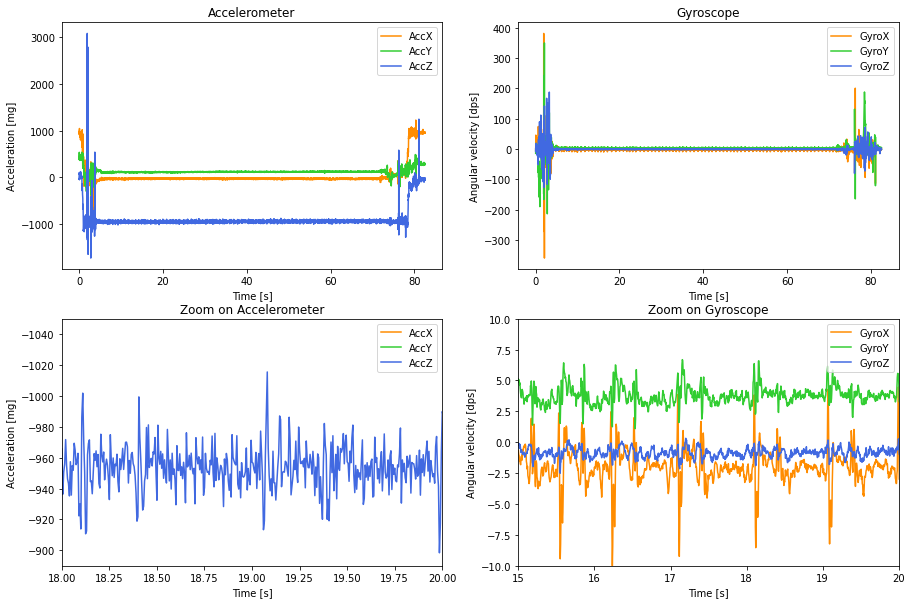

In [27]:
fig, axs = plt.subplots(2,2,figsize = (15,10))

# Accelerometer Plot
axs[0,0].plot(data_acc_gyr['Time'], data_acc_gyr['AccX'], color='darkorange', label='AccX')
axs[0,0].plot(data_acc_gyr['Time'], data_acc_gyr['AccY'], color='limegreen', label='AccY')
axs[0,0].plot(data_acc_gyr['Time'], data_acc_gyr['AccZ'], color='royalblue', label='AccZ')
axs[0,0].set_title( "Accelerometer")
axs[0,0].set_ylabel("Acceleration [mg]") 
axs[0,0].set_xlabel('Time [s]')
axs[0,0].legend(loc='best')

# Gyroscope Plot
axs[0,1].plot(data_acc_gyr['Time'], data_acc_gyr['GyroX'], color='darkorange', label='GyroX')
axs[0,1].plot(data_acc_gyr['Time'], data_acc_gyr['GyroY'], color='limegreen', label='GyroY')
axs[0,1].plot(data_acc_gyr['Time'], data_acc_gyr['GyroZ'], color='royalblue', label='GyroZ')
axs[0,1].set_title( "Gyroscope")
axs[0,1].set_ylabel("Angular velocity [dps]") 
axs[0,1].set_xlabel('Time [s]')
axs[0,1].legend(loc='best')

# Accelerometer Zoomed Plot
axs[1,0].plot(data_acc_gyr['Time'],data_acc_gyr['AccX'], color='darkorange', label='AccX')
axs[1,0].plot(data_acc_gyr['Time'],data_acc_gyr['AccY'], color='limegreen', label='AccY')
axs[1,0].plot(data_acc_gyr['Time'],data_acc_gyr['AccZ'], color='royalblue', label='AccZ')
axs[1,0].set_title( "Zoom on Accelerometer")
axs[1,0].set_ylabel("Acceleration [mg]") 
axs[1,0].set_xlabel('Time [s]')
axs[1,0].set_ylim([-890,-1050])
axs[1,0].set_xlim([18,20])
axs[1,0].legend(loc='best')

# Gyroscope Zoomed Plot
axs[1,1].plot(data_acc_gyr['Time'],data_acc_gyr['GyroX'], color='darkorange', label='GyroX')
axs[1,1].plot(data_acc_gyr['Time'],data_acc_gyr['GyroY'], color='limegreen', label='GyroY')
axs[1,1].plot(data_acc_gyr['Time'],data_acc_gyr['GyroZ'], color='royalblue', label='GyroZ')
axs[1,1].set_title( "Zoom on Gyroscope")
axs[1,1].set_ylabel("Angular velocity [dps]") 
axs[1,1].set_xlabel('Time [s]')
axs[1,1].set_ylim([-10,10])
axs[1,1].set_xlim([15,20])
axs[1,1].legend(loc='best')


# 2. Time and frequency analysis

## 2.1 Statistical Analysis

In [28]:
refined_data = data_acc_gyr[(data_acc_gyr['Time'] >= 10) & (data_acc_gyr['Time'] < 70)]

In [29]:
# statistic analysis on data selected for the analysis

# variance
var_accX = stat.variance(refined_data['AccX'])
var_accY = stat.variance(refined_data['AccY'])
var_accZ = stat.variance(refined_data['AccZ'])
var_gyroX = stat.variance(refined_data['GyroX'])
var_gyroY = stat.variance(refined_data['GyroY'])
var_gyroZ = stat.variance(refined_data['GyroZ'])
var_magnX = stat.variance(refined_data['MagnX'])
var_magnY = stat.variance(refined_data['MagnY'])
var_magnZ = stat.variance(refined_data['MagnZ'])
var_qw = stat.variance(refined_data['qw'])
var_qi = stat.variance(refined_data['qi'])
var_qj = stat.variance(refined_data['qj'])
var_qk = stat.variance(refined_data['qk'])
variance = [var_accX, var_accY, var_accZ, var_gyroX, var_gyroY, var_gyroZ, var_magnX, var_magnY, var_magnZ, var_qi, var_qj, var_qk, var_qw] 
# print('Variance:')
# print(var_accX, var_accY, var_accZ, var_gyroX, var_gyroY, var_gyroZ, var_magnX, var_magnY, var_magnZ, var_qi, var_qj, var_qk, var_qw, '\n')

columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ', 'qw', 'qi', 'qj', 'qk']

# correlation coefficient
corr_coeff = []
for v in columns:
  corr_coeff.append(np.corrcoef(refined_data[v], refined_data['Time'])[0,1])


# for x in corr_coeff:
#   print(x)

In [30]:
df_describe = refined_data.describe()
df_describe = df_describe.rename(columns={"Time": "Time [s]", "AccX": "AccX [mg]", "AccY": "AccY [mg]", "AccZ": "AccZ [mg]", "GyroX": "GyroX [rad/s]", "GyroY": "GyroY [rad/s]", "GyroZ": "GyroZ [rad/s]"})
df_describe.round(1)
df_descr = df_describe.iloc[:,1:].round(1)
df_descr

,AccX [mg],AccY [mg],AccZ [mg],GyroX [rad/s],GyroY [rad/s],GyroZ [rad/s],MagnX,MagnY,MagnZ,qw,qi,qj,qk
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,-30.7,115.6,-949.1,-2.1,3.7,-0.9,-211.6,-432.2,429.7,0.0,0.5,-0.8,-0.1
std,7.0,5.3,14.4,1.4,0.7,0.4,1.3,1.8,2.9,0.0,0.0,0.0,0.0
min,-66.9,85.8,-1015.5,-10.0,0.5,-2.5,-216.0,-439.0,418.0,0.0,0.5,-0.9,-0.1
25%,-35.3,112.1,-957.6,-2.7,3.3,-1.1,-212.0,-434.0,427.0,0.0,0.5,-0.9,-0.1
50%,-30.6,115.7,-949.5,-2.2,3.6,-0.9,-212.0,-432.0,429.0,0.0,0.5,-0.8,-0.1
75%,-26.0,119.1,-941.3,-1.5,4.0,-0.6,-211.0,-431.0,433.0,0.0,0.6,-0.8,-0.1
max,-5.4,147.4,-879.7,4.5,7.6,0.6,-207.0,-427.0,436.0,0.0,0.6,-0.8,-0.1


In [31]:
df2 = pd.DataFrame([variance, corr_coeff], columns=["AccX [mg]", "AccY [mg]", "AccZ [mg]", "GyroX [rad/s]", "GyroY [rad/s]", "GyroZ [rad/s]","MagnX","MagnY", "MagnZ","qw", "qi", "qj", "qk"])
df2.index = ['variance','corr_coeff']
df2 = df2.iloc[:,:].round(2)
df2

,AccX [mg],AccY [mg],AccZ [mg],GyroX [rad/s],GyroY [rad/s],GyroZ [rad/s],MagnX,MagnY,MagnZ,qw,qi,qj,qk
variance,49.08,28.40,207.29,2.00,0.51,0.13,1.79,3.38,8.57,0.00,0.0,0.0,0.00
corr_coeff,-0.11,0.53,0.26,-0.04,-0.06,-0.01,0.42,0.86,-0.87,0.89,1.0,1.0,-0.48


In [32]:
df_descr = df_descr.append(df2)
df_descr2 = df_descr.drop(["MagnX","MagnY", "MagnZ","qw", "qi", "qj", "qk"], axis=1)
columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
df_descr2

,AccX [mg],AccY [mg],AccZ [mg],GyroX [rad/s],GyroY [rad/s],GyroZ [rad/s]
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,-30.70,115.60,-949.10,-2.10,3.70,-0.90
std,7.00,5.30,14.40,1.40,0.70,0.40
min,-66.90,85.80,-1015.50,-10.00,0.50,-2.50
25%,-35.30,112.10,-957.60,-2.70,3.30,-1.10
50%,-30.60,115.70,-949.50,-2.20,3.60,-0.90
75%,-26.00,119.10,-941.30,-1.50,4.00,-0.60
max,-5.40,147.40,-879.70,4.50,7.60,0.60
variance,49.08,28.40,207.29,2.00,0.51,0.13
corr_coeff,-0.11,0.53,0.26,-0.04,-0.06,-0.01


## 2.2 Fourier Analysis

(0.0, 1.0)

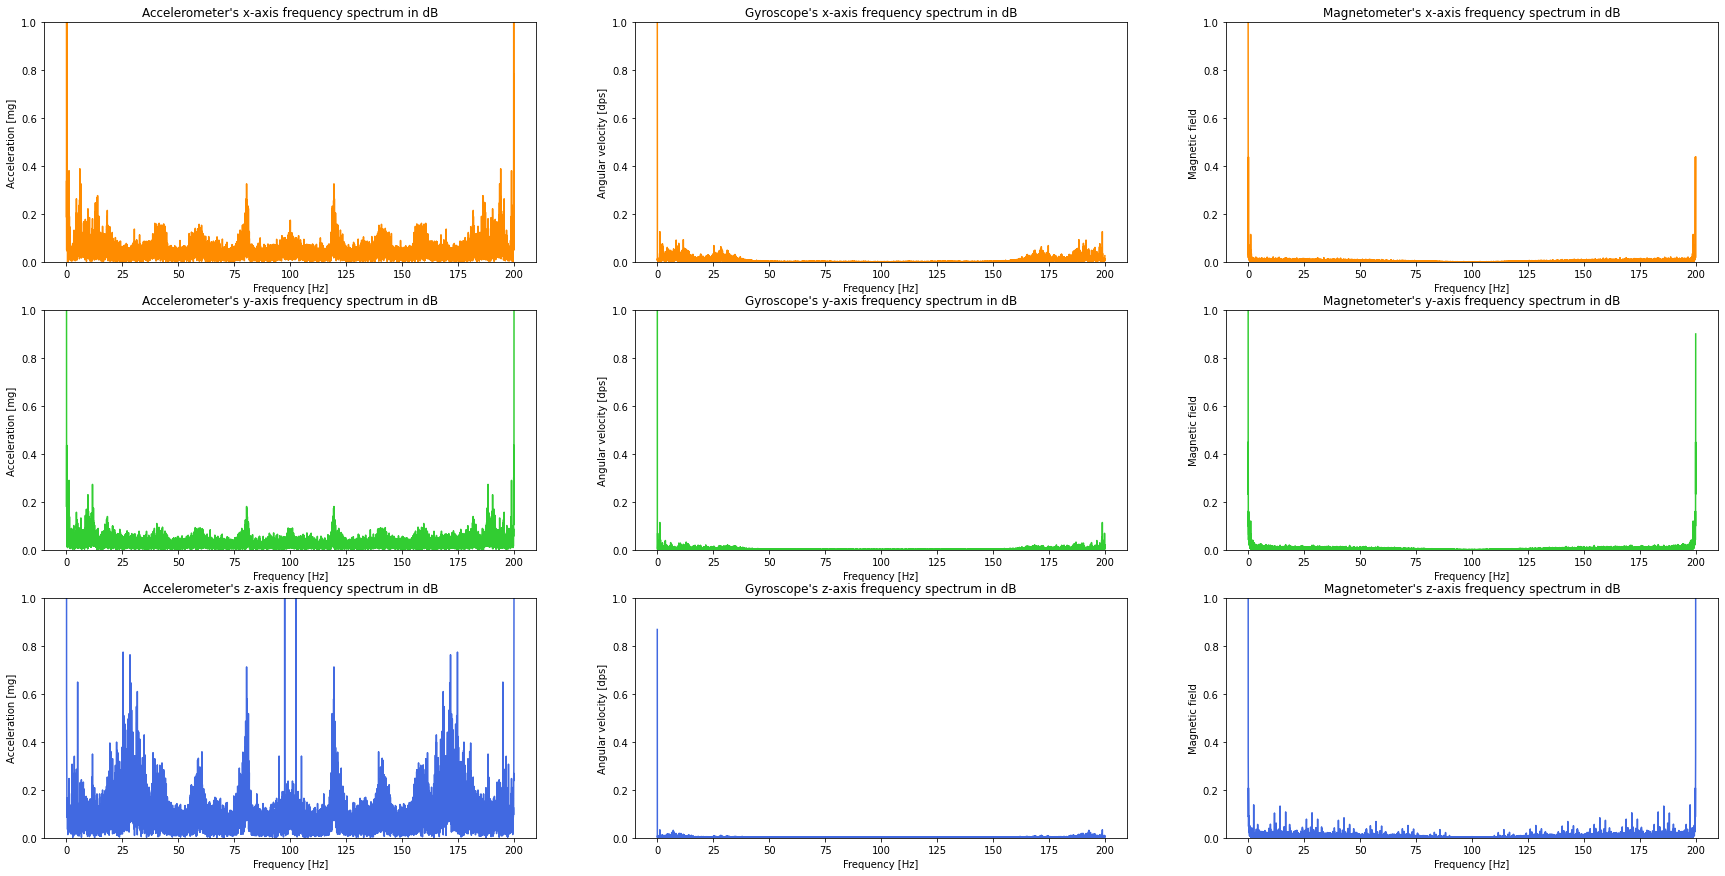

In [33]:
#Computing the fft of the data

N = len(refined_data)

fft_data = pd.DataFrame(columns=['freq', 'AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ'])

for data in columns:
  fft_data[data] = np.abs(np.fft.fft(refined_data[data])/N)

fft_data['freq'] = np.arange(N)*(log_freq)/N



fig, axs = plt.subplots(3, 3, figsize = (30,15))

#Plotting the accelerometer
axs[0,0].plot(fft_data['freq'], fft_data['AccX'], color='darkorange')
axs[0,0].set_title( "Accelerometer's x-axis frequency spectrum in dB")
axs[0,0].set_ylabel("Acceleration [mg]")
axs[0,0].set_xlabel('Frequency [Hz]')
axs[0,0].set_ylim([0,1])

axs[1,0].plot(fft_data['freq'], fft_data['AccY'], color='limegreen')
axs[1,0].set_title( "Accelerometer's y-axis frequency spectrum in dB")
axs[1,0].set_ylabel("Acceleration [mg]")
axs[1,0].set_xlabel('Frequency [Hz]')
axs[1,0].set_ylim([0,1])

axs[2,0].plot(fft_data['freq'], fft_data['AccZ'], color='royalblue')
axs[2,0].set_title( "Accelerometer's z-axis frequency spectrum in dB")
axs[2,0].set_ylabel("Acceleration [mg]")
axs[2,0].set_xlabel('Frequency [Hz]')
axs[2,0].set_ylim([0,1])


#Plotting the gyroscope
axs[0,1].plot(fft_data['freq'], fft_data['GyroX'], color='darkorange')
axs[0,1].set_title( "Gyroscope's x-axis frequency spectrum in dB")
axs[0,1].set_ylabel("Angular velocity [dps]")
axs[0,1].set_xlabel('Frequency [Hz]')
axs[0,1].set_ylim([0,1])

axs[1,1].plot(fft_data['freq'], fft_data['GyroY'], color='limegreen')
axs[1,1].set_title( "Gyroscope's y-axis frequency spectrum in dB")
axs[1,1].set_ylabel("Angular velocity [dps]")
axs[1,1].set_xlabel('Frequency [Hz]')
axs[1,1].set_ylim([0,1])

axs[2,1].plot(fft_data['freq'], fft_data['GyroZ'], color='royalblue')
axs[2,1].set_title( "Gyroscope's z-axis frequency spectrum in dB")
axs[2,1].set_ylabel("Angular velocity [dps]")
axs[2,1].set_xlabel('Frequency [Hz]')
axs[2,1].set_ylim([0,1])


#Plotting the magnetometer
axs[0,2].plot(fft_data['freq'], fft_data['MagnX'], color='darkorange')
axs[0,2].set_title( "Magnetometer's x-axis frequency spectrum in dB")
axs[0,2].set_ylabel("Magnetic field")
axs[0,2].set_xlabel('Frequency [Hz]')
axs[0,2].set_ylim([0,1])

axs[1,2].plot(fft_data['freq'], fft_data['MagnY'], color='limegreen')
axs[1,2].set_title( "Magnetometer's y-axis frequency spectrum in dB")
axs[1,2].set_ylabel("Magnetic field")
axs[1,2].set_xlabel('Frequency [Hz]')
axs[1,2].set_ylim([0,1])

axs[2,2].plot(fft_data['freq'], fft_data['MagnZ'], color='royalblue')
axs[2,2].set_title( "Magnetometer's z-axis frequency spectrum in dB")
axs[2,2].set_ylabel("Magnetic field")
axs[2,2].set_xlabel('Frequency [Hz]')
axs[2,2].set_ylim([0,1])

# 3. Filter

(32.0, 34.0)

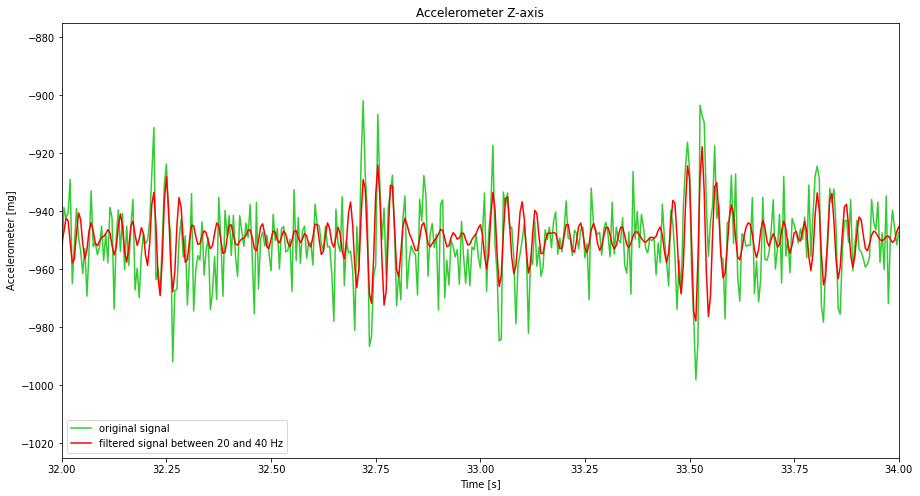

In [34]:
b, a = sc.signal.iirfilter(4, [25,40] , btype='bandpass', ftype='butter', fs=log_freq)
filtered_data = filtfilt(b, a, refined_data['AccZ']) + refined_data['AccZ'].mean()


fig, ax = plt.subplots(figsize = (15,8))

ax.plot(refined_data['Time'], refined_data['AccZ'], color='limegreen', label='original signal')
ax.plot(refined_data['Time'], filtered_data, color='red', label='filtered signal between 20 and 40 Hz')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Accelerometer [mg]')
ax.set_title('Accelerometer Z-axis')
ax.legend(loc='lower left')
ax.set_ylim(-1025, -875)
ax.set_xlim(32, 34)


#4 Metrics

## 4.1 Heart Beat Per Minute (BPM)

In [35]:
M = len(filtered_data)

#Finding the peaks of the refined dataset
x_peaks = [0,]
y_peaks = [filtered_data[0],]

for i in range(1,M-1):
    if (np.sign(filtered_data[i]-filtered_data[i-1])==1) & (np.sign(filtered_data[i]-filtered_data[i+1])==1):
        x_peaks.append(i)
        y_peaks.append(filtered_data[i])

x_peaks.append(M-1)
y_peaks.append(filtered_data[-1])


#The envelope function creates a higher profile for the dataset
envelope = sc.interpolate.interp1d(x_peaks, y_peaks, 'cubic')

x = np.arange(M)
upper_envelope = envelope(x)
time = x/200+10
threshold = -927

envelope_mean = np.mean(upper_envelope)
print('mean',envelope_mean)
envelope_var = np.var(upper_envelope)
print('var',envelope_var)
envelope_std = np.std(upper_envelope)
print('std',envelope_std)

threshold2 = envelope_mean+(envelope_std*2)

mean -941.1232875900231
var 50.172571961016736
std 7.083259981182163


In [36]:
df_max = pd.DataFrame({'Time':time, 'Filtered':upper_envelope})
df_max['max'] = df_max.iloc[argrelextrema(df_max.Filtered.values, np.greater_equal, order=40)[0]]['Filtered']
index_nan = df_max[df_max['max'].isnull()]
df_max.drop(index_nan.index, inplace=True)

df_max

,Time,Filtered,max
45,10.225,-933.553739,-933.553739
159,10.795,-921.747404,-921.747404
216,11.080,-933.393962,-933.393962
346,11.730,-921.420593,-921.420593
409,12.045,-937.842503,-937.842503
...,...,...,...
11682,68.410,-928.165952,-928.165952
11744,68.720,-929.909037,-929.909037
11860,69.300,-916.908138,-916.908138
11925,69.625,-930.682699,-930.682699


Text(0.5, 0, 'BPM')

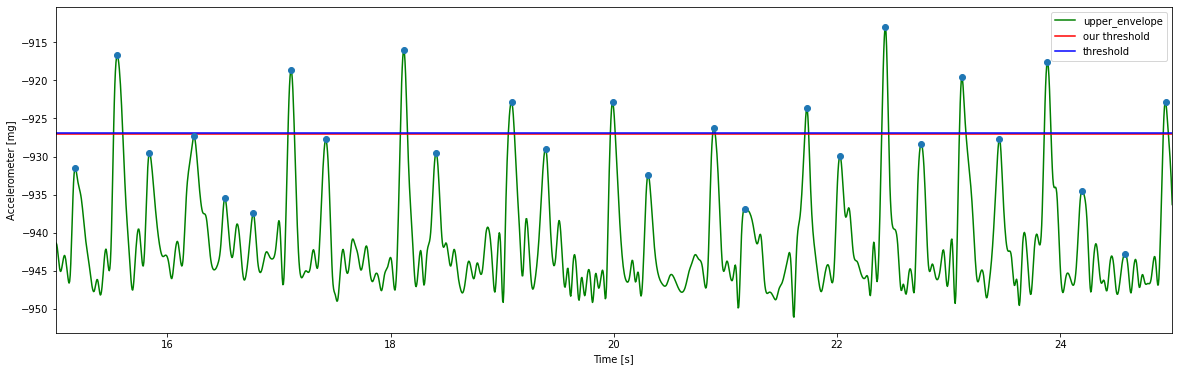

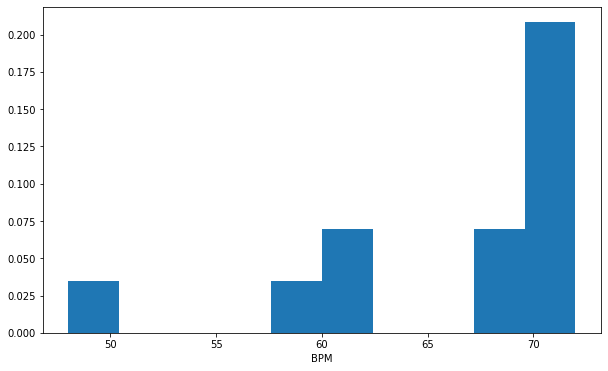

In [37]:
#Plotting the envelope function
fig = plt.figure(figsize = (20,6))

plt.plot(time, upper_envelope, 'g', label = 'upper_envelope')
plt.axhline(threshold, color = 'r', label = 'our threshold')
plt.axhline(threshold2, color = 'b', label = 'threshold')
plt.plot(df_max['Time'], df_max['max'], 'o')
plt.xlim([15,25])
plt.legend(loc='best')
plt.xlabel('Time [s]')
plt.ylabel('Accelerometer [mg]')


#Estimating the BPM
bins=12

bpm_estimation = pd.DataFrame()
interval = np.arange(0.50, 0.80, 0.05)
for x in interval:
  i=0
  n_beats = np.zeros(bins)
  while (i < M):
    if (upper_envelope[i] > threshold):
      n_beats[m.floor(i/(M/bins))] += 1
      i += int(M/(60/x))
    else:
      i+=1
  bpm_estimation.insert(loc = 0, column=int(100*x), value=n_beats)

bpm_avg = bpm_estimation.mean(axis=1)*bins

fig = plt.figure(figsize = (10,6))
plt.hist(bpm_avg, density=True)
plt.xlabel('BPM')

## 4.2 Heart Rate Variability (HRV)

In [38]:
# 1 method

thresh_HRV_df = pd.DataFrame()
thresh = []

low_bound = int(threshold2-3)
up_bound = int(threshold2+3)

for i in range(low_bound, up_bound):
  max_val = []
  for l in range(1,len(upper_envelope)):
    if upper_envelope[l]>i:
      if upper_envelope[l]>upper_envelope[l-1] and upper_envelope[l]>upper_envelope[l+1]:
        max_val.append(l/200+10)
  time_1 = pd.Series(max_val[0:len(max_val)-2])
  time_2 = pd.Series(max_val[1:len(max_val)-1])
  thresh_HRV_df["HRV "+str(i)] = time_2-time_1
  thresh.append(str(i))
  
# print(thresh_HRV_df)

for c in thresh_HRV_df.columns:
  thresh_HRV_df[thresh_HRV_df[c] > 0.4]

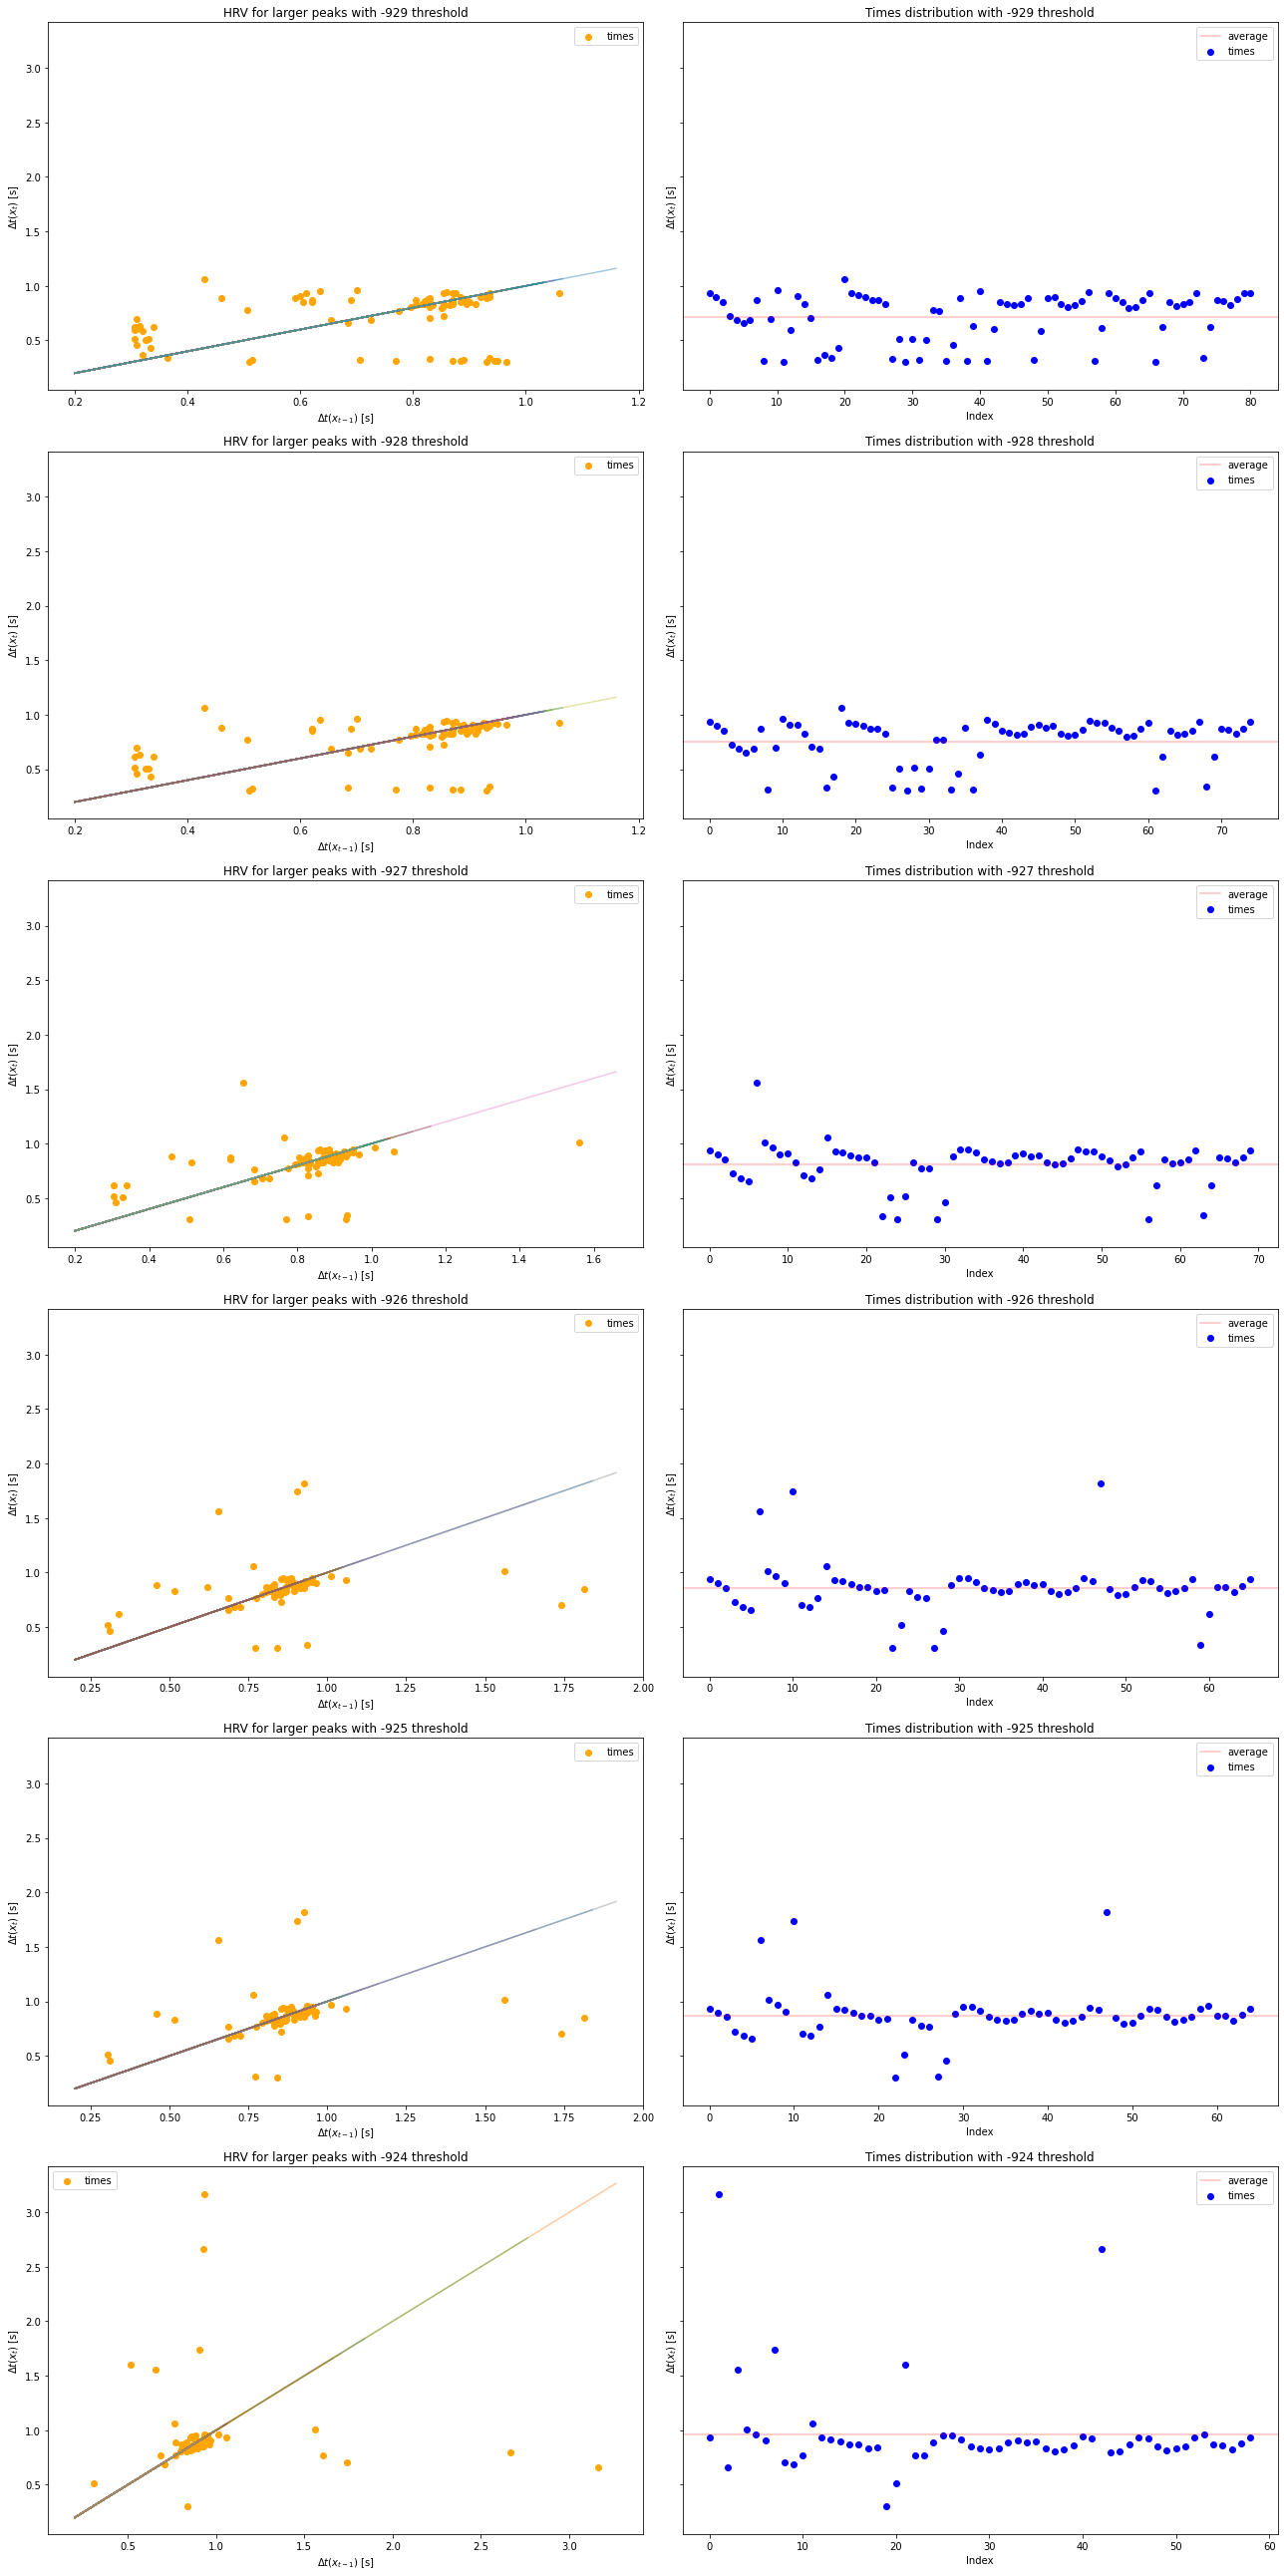

In [39]:
fig, ax = plt.subplots(len(thresh), 2, figsize=(18, 36), sharey = True)

i=0
for t in thresh:
  x = np.linspace(0.2, thresh_HRV_df["HRV "+t]+0.1,100)
  ax[i,0].scatter(thresh_HRV_df["HRV "+t][:-1], thresh_HRV_df["HRV "+t][1:], color = 'orange', label = "times")
  ax[i,0].set_title("HRV for larger peaks with "+t+" threshold")
  ax[i,0].set_xlabel("$\Delta t (x_{t-1})$ [s]")
  ax[i,0].set_ylabel("$\Delta t (x_{t})$ [s]")
  ax[i,0].plot(x,x, alpha = 0.4)
  ax[i,0].legend()

  ax[i,1].scatter(np.arange(len(thresh_HRV_df["HRV "+t])), thresh_HRV_df["HRV "+t], color = 'blue', label = "times")
  ax[i,1].set_title("Times distribution with "+t+" threshold")
  ax[i,1].set_xlabel("Index")
  ax[i,1].set_ylabel("$\Delta t (x_{t})$ [s]")
  ax[i,1].axhline(thresh_HRV_df["HRV "+t].mean(), color = 'red', alpha = 0.25, label = 'average')
  ax[i,1].legend()
  i+=1

plt.tight_layout()
plt.show()

In [40]:
HRV_avg = []
bpm_HRV_avg = []
for x in thresh_HRV_df:
  avg = thresh_HRV_df[x].mean()
  HRV_avg.append(avg)
  bpm_HRV_avg.append(60/avg)

print(mean(HRV_avg), mean(bpm_HRV_avg))

0.8280975469811627 73.1573657912152


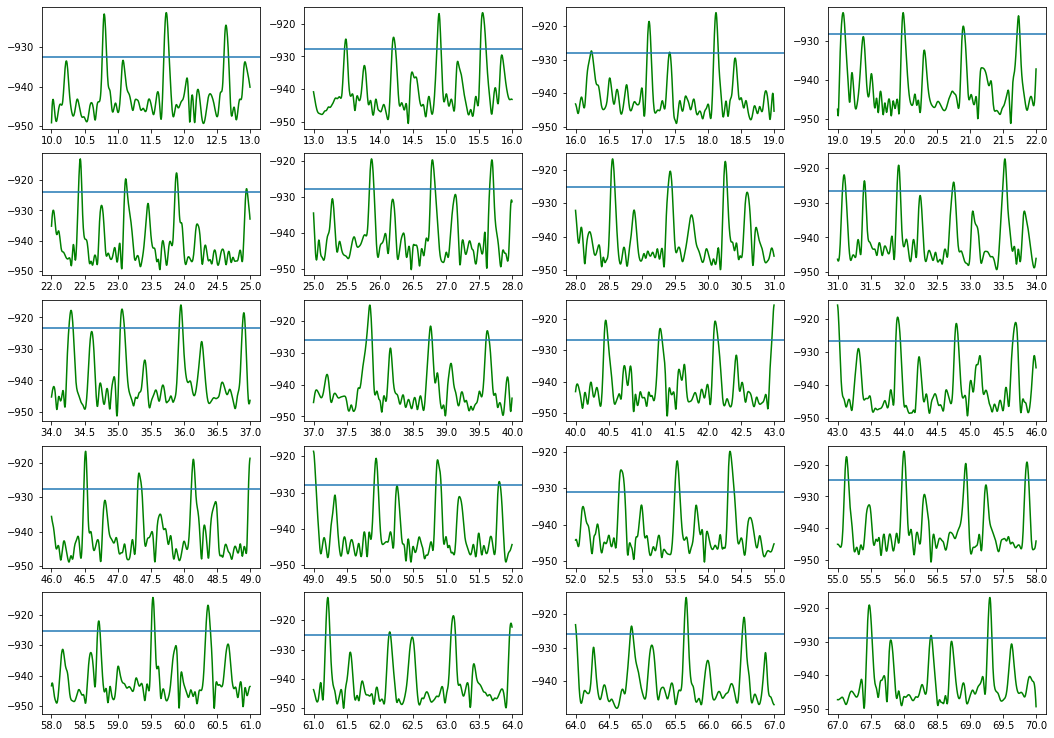

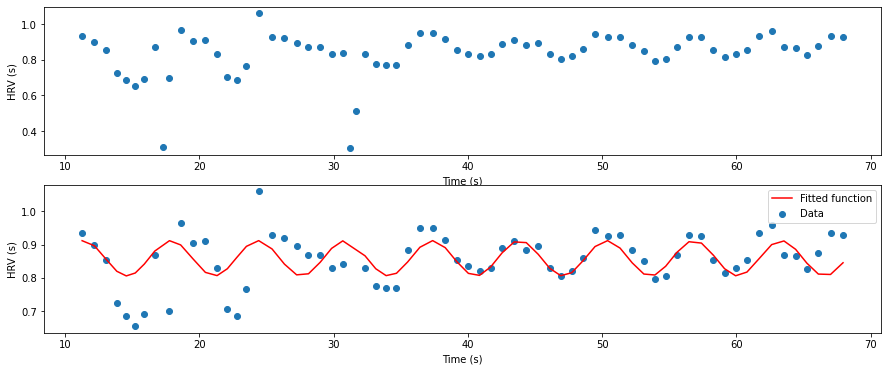

In [41]:
# 2 method

slc_factor = [1.012, 1.012, 1.013, 1.0058, 1.012, 1.009, 1.009, 1.01, 1.008, 1.012, 1.012, 1.012, 1.012, 1.01, 1.012, 1.01, 1.012, 1.014, 1.012, 1.013]
slc_thresh = []
slices = 20

#Plotting slices with relative threshold
fig, axs = plt.subplots(5,4,figsize = (18,13))

for i in range(slices):
  n1 = int((M/slices))*i
  n2 = int((M/slices))*(i+1)
  t1 = int(n1/200)+10
  t2 = int(n2/200)+10
  sliced_envelope = upper_envelope[n1 : n2]
  slc_thresh.append(sliced_envelope.max()*slc_factor[i])
  # print((t2-t1)/0.005, len(sliced_envelope))
  axs[m.floor(i/4), i%4].plot(np.arange(t1, t2, 0.005), sliced_envelope, color='g')
  axs[m.floor(i/4), i%4].axhline(y=slc_thresh[i])


HRV_df = pd.DataFrame()

#Finding the position in time of the peaks
peak_time = []
for i in range(M):
  if (upper_envelope[i] > slc_thresh[m.floor(i/(M/slices))]):
    if(upper_envelope[i] > upper_envelope[i+1] and upper_envelope[i] > upper_envelope[i-1]):
      peak_time.append(i/200+10)


HRV_df['time_1'] = pd.Series(peak_time[0:len(peak_time)-2])
HRV_df['time_2'] = pd.Series(peak_time[1:len(peak_time)-1])
HRV_df['timestamp'] = (HRV_df['time_2']+HRV_df['time_1'])/2
HRV_df['HRV'] = HRV_df['time_2']-HRV_df['time_1']
HRV_df = HRV_df.drop(columns=['time_1', 'time_2'])



fig, axs = plt.subplots(2,1,figsize = (15,6))
axs[0].scatter(HRV_df['timestamp'], HRV_df['HRV'])
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("HRV (s)")

HRV_df = HRV_df[HRV_df['HRV'] > 0.55]
axs[1].scatter(HRV_df['timestamp'], HRV_df['HRV'], label='Data')
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("HRV (s)")

def fit_func(x, a, b, c):
    return a * np.sin(b * x) + c

params, params_covariance = sc.optimize.curve_fit(fit_func, HRV_df['timestamp'], HRV_df['HRV'])
axs[1].plot(HRV_df['timestamp'], fit_func(HRV_df['timestamp'], params[0], params[1], params[2]), label='Fitted function', color='r')
axs[1].legend(loc='best')

In [42]:
HRV_avg = HRV_df['HRV'].mean()
BPM_avg = 60/HRV_avg

print('HRV averange: ', HRV_avg)
print('BPM averange: ', BPM_avg)

HRV averange:  0.8558333333333333
BPM averange:  70.10710808179162


In [43]:
# 3 method
df_max.reset_index(inplace=True, drop=True)
df_max_threshold = df_max[df_max['max']>threshold2]

index = []
for i in range(1,len(df_max_threshold)):
  if df_max_threshold.index[i-1] not in index and df_max_threshold['Time'][df_max_threshold.index[i]]-df_max_threshold['Time'][df_max_threshold.index[i-1]]<0.5 and df_max_threshold['Time'][df_max_threshold.index[i+1]]-df_max_threshold['Time'][df_max_threshold.index[i-1]]<1.5:
     index.append(df_max_threshold.index[i])


df_max_threshold.drop(index, inplace=True)


df_max_threshold

c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Time,Filtered,max
1,10.795,-921.747404,-921.747404
3,11.730,-921.420593,-921.420593
5,12.630,-924.587700,-924.587700
7,13.485,-924.752876,-924.752876
9,14.210,-924.182044,-924.182044
...,...,...,...
136,64.845,-923.515420,-923.515420
138,65.670,-914.925020,-914.925020
140,66.545,-920.888674,-920.888674
142,67.480,-919.129302,-919.129302


In [44]:
for i in range(len(df_max_threshold)-1):
  if df_max_threshold['Time'][df_max_threshold.index[i+1]]-df_max_threshold['Time'][df_max_threshold.index[i]]>1.5:
    if df_max_threshold.index[i]+1!=df_max_threshold.index[i+1]:
      temp_df = df_max[:][df_max_threshold.index[i]+1:df_max_threshold.index[i+1]]
      max_id = int(temp_df.idxmax()['max'])
      max_val = df_max[:][max_id:max_id+1]
      df_max_threshold = df_max_threshold.append(max_val)

df_max_threshold = df_max_threshold.sort_index(ascending=True)
df_max_threshold

,Time,Filtered,max
1,10.795,-921.747404,-921.747404
3,11.730,-921.420593,-921.420593
5,12.630,-924.587700,-924.587700
7,13.485,-924.752876,-924.752876
9,14.210,-924.182044,-924.182044
...,...,...,...
138,65.670,-914.925020,-914.925020
140,66.545,-920.888674,-920.888674
142,67.480,-919.129302,-919.129302
144,68.410,-928.165952,-928.165952


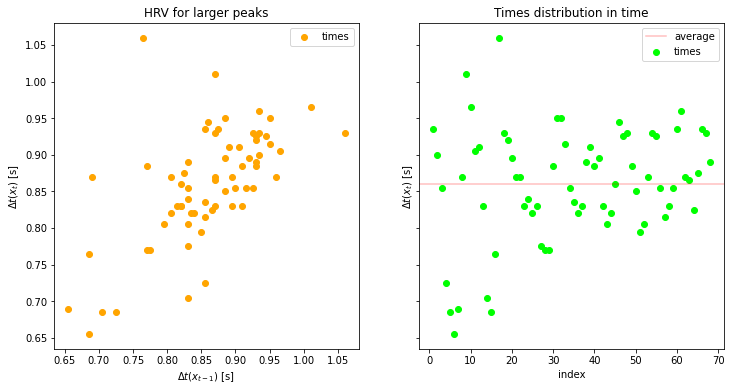

In [45]:
df_max_threshold.reset_index(inplace=True, drop=True)
df_max_threshold_1 = df_max_threshold[['Time', 'max']]
df_max_threshold_1 = df_max_threshold_1[(df_max_threshold['max'] < 0)]  
df_max_threshold_1 = df_max_threshold_1.diff()
df_max_threshold_1.dropna()

x = np.linspace(0.2, max(df_max_threshold_1['Time'])+ 0.1 , 100)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

ax[0].scatter(df_max_threshold_1['Time'].values[:-1], df_max_threshold_1['Time'].values[1:], color = 'orange', label = "times")
ax[0].set_title("HRV for larger peaks")
ax[0].set_xlabel("$\Delta t (x_{t-1})$ [s]")
ax[0].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[0].plot(x,x, alpha=0.4)
ax[0].legend()


ax[1].scatter(np.arange(len(df_max_threshold_1['Time'].values)), df_max_threshold_1['Time'].values, color = 'lime', label = "times")
ax[1].set_title("Times distribution in time")
ax[1].set_xlabel("index")
ax[1].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[1].axhline(df_max_threshold_1['Time'].mean(), color = 'red', alpha = 0.25, label = 'average')
ax[1].legend()

In [46]:
HRV_avg = df_max_threshold_1['Time'].mean()
BPM_avg = 60/HRV_avg

print('HRV averange: ', HRV_avg)
print('BPM averange: ', BPM_avg)

HRV averange:  0.8603676470588235
BPM averange:  69.7376292624562
